m_init[1.0, 0.8929795115692493, 0.9027452929509335, 1.0, 1.1906393487589988, 1.5045754882515563]


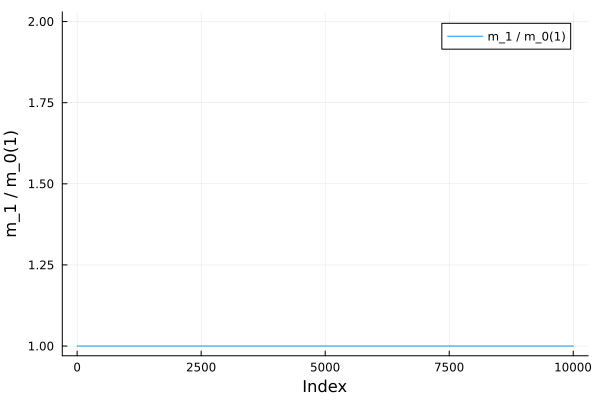

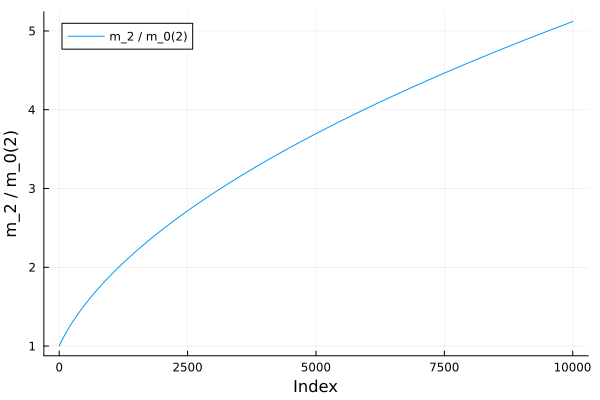

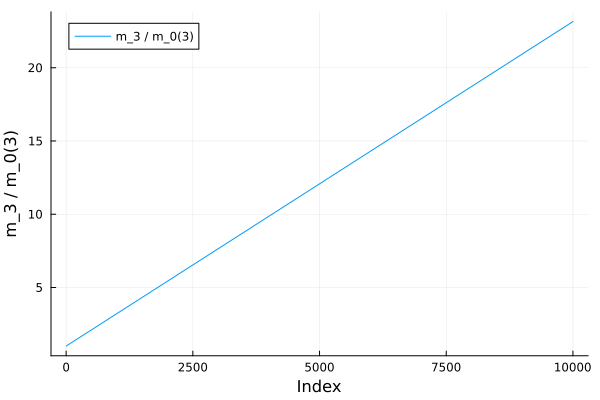

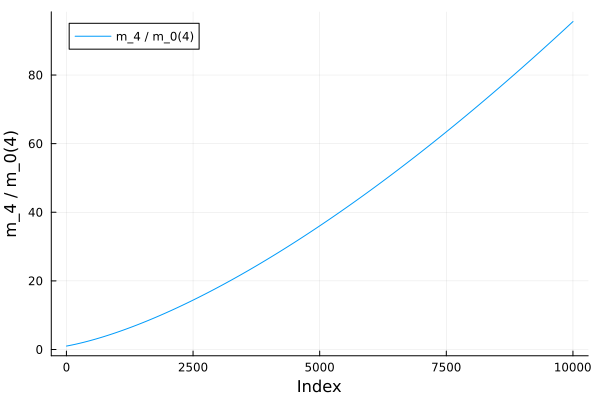

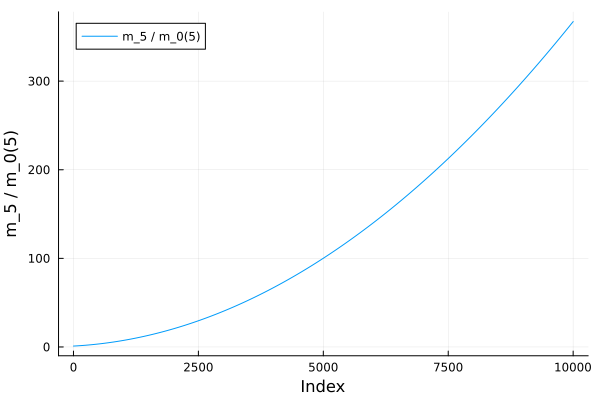

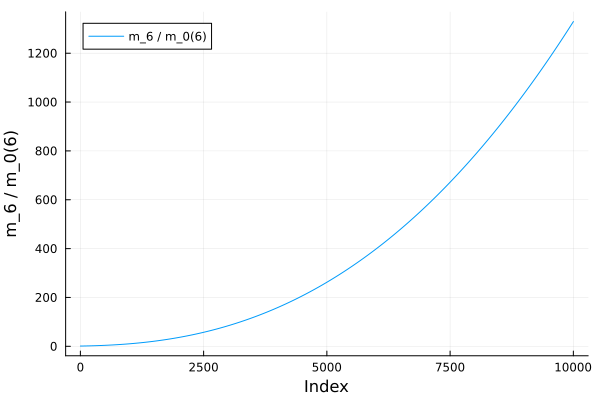

In [3]:

using CSV
using DataFrames
using Plots
include("MIA.jl")
using Base, LinearAlgebra, SpecialFunctions, SciPy

function TimeStepper(f, t_range, y0, dt; method="ExplicitEuler", t_eval=nothing)
    y0_shape = size(y0)
    t = t_range[1]:dt:t_range[2]

    if ndims(y0) == 2
        y = zeros(Float64, length(t), y0_shape[1], y0_shape[2])
    elseif ndims(y0) == 1
        y = zeros(Float64, length(t), y0_shape[1])
    end

    y[1, :] .= y0

   if method == "ExplicitEuler"
        for n in 1:length(t)-1
            t_n = t[n]
            y_n = f(t_n, y[n, :]) * dt + y[n, :]
            y[n + 1, :] .= y_n
        end
    else
        error("Unsupported method: $method")
    end

    return (t=t, y=y)
end



# Parameters to be set by the user
n0 = 1.0 # Initial total number density
v0 = 1.0 # System constant
N = 3 # Order of approximation / number of nodes
dimension = 3 # Set to 3 if the internal coordinate is additive, set to 1 if the internal coordinate is length
method = "ExplicitEuler" # Time-integration scheme, choose from: 'RK45', 'RK23', 'Radau', 'BDF', 'LSODA', 'ExplicitEuler', 'ImplicitEuler', 'Trapezoidal'
t_range = [0.0, 10] # Start and end times
dt = 0.001 # Neccessary if using explicit Euler, implicit Euler or Trapezoidal

# Initial values of the moments, default values are same as used in report for homogeneous case
m_init = [n0 * v0^((i-1)/3) * gamma(1 + (i-1)/3) for i in 1:2*N]
println("m_init",m_init)
# Dependence of the source terms on the internal coordinate - nodes is an array of size N
function growth_rate(nodes)
    return ones(length(nodes))
end
growth = zeros(2 * N)
   
    
function source(t, m)
    Realisable(m, N)
    weights, nodes = Prod_Diff(m, N)



    for k in 1:2 * N
        if k > 1
            growth[k] = (k-1) * sum(nodes .^ (k - 3) .* weights .* growth_rate(nodes))
        end

    end
    return growth
    end
   
sol = TimeStepper(source, t_range, m_init, dt, method=method)
CSV.write("output_agg_jl.csv",DataFrame(hcat(sol.y),:auto))






df = CSV.File("output_dep_jl.csv") |> DataFrame

# Iterate over columns and plot
for i in 1:length(names(df))
    column_name = names(df)[i]
    constant = m_init[i]
    
    # Convert the y-axis data to a numerical type
    y_data = df[!, column_name] / constant
    
    plot(1:size(df, 1), y_data, label="m_$i / m_0($i)")
    # Add labels and legend
    xlabel!("Index")
    ylabel!("m_$i / m_0($i)")
    

    # Show the plot
    display(Plots.plot!()) 
end
